# Лекция 16. Scipy_1

1. **`scipy.integrate`**
    - интегрирование скалярных функций
    - **интегрирование ОДУ**
2. `scipy.interpolate`
3. `scipy.optimize`
4. ...

https://docs.scipy.org/doc/scipy/reference/

In [1]:
!pip install scipy

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Интегрирование ОДУ

In [3]:
from scipy.integrate import ode, solve_ivp

## [Математический маятник](https://ru.wikipedia.org/wiki/Математический_маятник)

Уравнение движения:

$\ddot \theta + \frac{g}{L}\sin(\theta) = 0$

Без ограничения общности можно рассмотреть безразмерное уравнение:

$\ddot \theta + \sin(\theta) = 0$

ОДУ порядка 2 и более можно свести к системе ОДУ первого порядка:

$\dot \theta = \omega$

$\dot \omega = - \sin(\theta)$

Слева расположены первые производные, а справа - содержимое модели движения. Такое представление является стандартным, поэтому для анализа модели реализуют **правую часть** системы ОДУ как функцию.

In [4]:
from math import sin

def eq(t, s):
    '''
    Уравнения движения математического маятника
    
    Parameters
    ----------
    
    t: scalar
        time
        
    s: np.array
        вектор состояния [theta, omega]
        
    Return
    ------
    
    ds: np.array
        производная вектора состояния по времени
    '''
    ds = np.empty_like(s)
    theta, omega = s
    ds[0] = omega
    ds[1] = -sin(theta)
    return ds

### Задача Коши

Задача с начальными условиями, **i**nitial **v**alue **p**roblem

### Решение при помощи `solve_ivp`

In [5]:
t0 = 0
s0 = np.array([0, 0.1])
t1 = 2*np.pi

sol = solve_ivp(eq, # правая часть СОДУ 
                [t0, t1],
                s0, # начальный вектор состояния
                method='DOP853', # метод численного интегрирования
                max_step=0.1, # максимальный шаг по времени
                rtol=1e-12, # относительная погрешность
                atol=1e-12  # абсолютная погрешность
               )

In [6]:
%%timeit
sol = solve_ivp(eq, # правая часть СОДУ 
                [t0, t1],
                s0, # начальный вектор состояния
                method='DOP853', # метод численного интегрирования
                max_step=0.1, # максимальный шаг по времени
                rtol=1e-12, # относительная погрешность
                atol=1e-12  # абсолютная погрешность
               )

8.85 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
sol.y.shape

(2, 65)

(-0.1100357086784088,
 0.10992977895705743,
 -0.10998145426541726,
 0.10999911686978178)

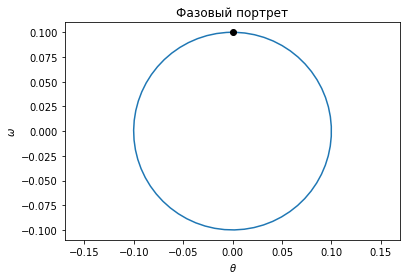

In [8]:
plt.plot(*sol.y)
plt.plot(*s0, 'ok')
plt.title('Фазовый портрет')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\omega$')
plt.axis('equal')

### Векторизованный вариант

In [9]:
def eqv(t, s):
    '''
    Уравнения движения математического маятника.
    Векторизованный вариант.
    
    Parameters
    ----------
    
    t: scalar
        time
        
    s: np.array (n*2,)
        вектор состояния [theta0, omega0, theta1, omega1, ...]
        
    Return
    ------
    
    ds: np.array
        производная вектора состояния по времени
    '''
    ds = np.empty_like(s)
    theta, omega = s[::2], s[1::2]
    ds[::2] = omega
    ds[1::2] = -np.sin(theta)
    return ds

In [10]:
t0 = 0
s0 = np.array([1, 0, 2, 0, np.pi-0.1, 0])
t1 = 2*np.pi

solv = solve_ivp(eqv, # правая часть СОДУ 
                [t0, t1],
                s0, # начальный вектор состояния
                method='DOP853', # метод численного интегрирования
                max_step=0.1, # максимальный шаг по времени
                rtol=1e-12, # относительная погрешность
                atol=1e-12  # абсолютная погрешность
                )

In [11]:
solv.y.shape

(6, 65)

(-2.8213323571922646,
 3.320779558865129,
 -2.1802350918275093,
 1.8665188516741733)

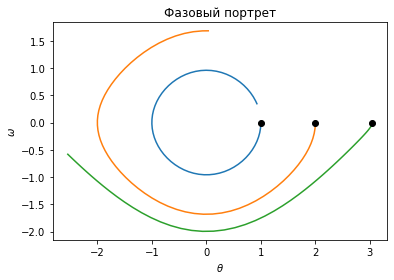

In [12]:
plt.plot(solv.y[::2].T, solv.y[1::2].T);
plt.plot(s0[::2], s0[1::2], 'ok')
plt.title('Фазовый портрет')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\omega$')
plt.axis('equal')

### Задание

Построить на одном рисунке фазовые портреты для 100 случайных начальных векторов состояния $s = (\theta, \omega)$ в квадрате [0, 1] x [1.5, 2.5]

### События `events`

In [13]:
# событийная функция должна обращаться в 0 при наступлении описываемого ей события
# корни этой функции будут вычислены с точностью интегрирования

def event(t, s):
    return s[0]

# терминальное событие позволит остановить интегрирование при его наступлении
event.terminal = True

# направление, в котором будет достигнут ноль событийной функции
# -1 означает, что функция пересекает ноль от положительных значений в отрицательные
event.direction = -1

In [14]:
t0 = 0
s0 = np.array([np.pi-0.000001, 0])
t1 = 100

sole = solve_ivp(eq, # правая часть СОДУ 
                [t0, t1],
                s0, # начальный вектор состояния
                method='DOP853', # метод численного интегрирования
                max_step=0.1, # максимальный шаг по времени
                rtol=1e-12, # относительная погрешность
                atol=1e-12,  # абсолютная погрешность
                events = [event],
               )

In [15]:
# рассчитанные моменты наступления событий
sole.t_events

[array([15.8949521])]

In [16]:
# период колебаний в данном случае можно рассчитать так
sole.t_events[0] * 4

array([63.5798084])

(-0.15707958267948913,
 3.2986712362692825,
 -2.0999999999993184,
 0.09999999999996755)

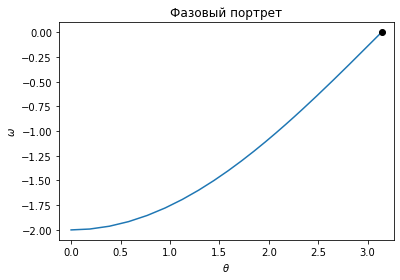

In [17]:
plt.plot(*sole.y);
plt.plot(*s0, 'ok')
plt.title('Фазовый портрет')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\omega$')
plt.axis('equal')

In [18]:
sole.t_events[0]/2*np.pi

array([24.96773237])

### Задание

Построить график зависимости периода колебаний маятника от начальной скорости $\omega$ в интервале (0, 2).

### Решение с использованием класса `ode`

In [19]:
integrator = ode(eq)
dt = 0.1
integrator.set_integrator('dop853', atol=1e-12, rtol=1e-12, max_step=dt)

In [20]:
t0 = 0
s0 = np.array([0, 0.1])
t1 = 2*np.pi

integrator.set_initial_value(s0, t0)

n = int((t1 - t0) / dt) + 1
dt = (t1 - t0) / n
states = np.empty((n+1, 2))
time = np.empty(n+1)

time[0] = t0
states[0] = s0
for i in range(n):
    time[i+1] = dt * (i + 1)
    states[i+1] = integrator.integrate(time[i+1])

In [21]:
%%timeit
integrator = ode(eq)
dt = 0.1
integrator.set_integrator('dop853', atol=1e-12, rtol=1e-12, max_step=dt)
integrator.set_initial_value(s0, t0)

n = int((t1 - t0) / dt) + 1
dt = (t1 - t0) / n
states = np.empty((n+1, 2))
time = np.empty(n+1)

time[0] = t0
states[0] = s0
for i in range(n):
    time[i+1] = dt * (i + 1)
    states[i+1] = integrator.integrate(time[i+1])

2.5 ms ± 42.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


(-0.11000369072628695,
 0.11001386852396938,
 -0.10987956528338597,
 0.10999426501349457)

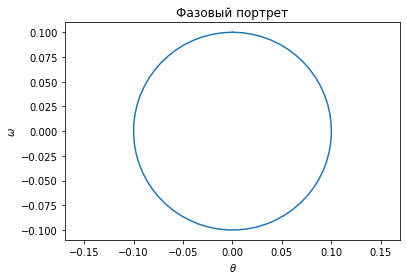

In [22]:
plt.plot(*states.T);
#plt.plot(*states[:1].T, 'ok');
plt.title('Фазовый портрет')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\omega$')
plt.axis('equal')

### Использование `solout` функции

In [23]:
t_lst = []
s_lst = []
def solout(t, s):
    t_lst.append(t)
    s_lst.append(s.copy())

In [24]:
t0 = 0
s0 = np.array([0, 0.1])
t1 = 2*np.pi

In [25]:
%%timeit
t_lst = []
s_lst = []
integrator = ode(eq)
dt = 0.1
integrator.set_integrator('dop853', atol=1e-12, rtol=1e-12, max_step=dt)
integrator.set_initial_value(s0, t0)
integrator.set_solout(solout)
integrator.integrate(t1)

1.93 ms ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
t_lst = []
s_lst = []
integrator = ode(eq)
dt = 0.1
integrator.set_integrator('dop853', atol=1e-12, rtol=1e-12, max_step=dt)
integrator.set_initial_value(s0, t0)
integrator.set_solout(solout)
integrator.integrate(t1)

array([-0.00039325,  0.09999923])

(-0.11003643944241198,
 0.10992459328194926,
 -0.10997932455332148,
 0.10999901545492008)

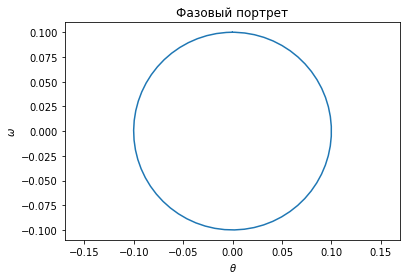

In [27]:
plt.plot(*np.array(s_lst).T);
#plt.plot(*states[:1].T, 'ok');
plt.title('Фазовый портрет')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\omega$')
plt.axis('equal')

### Задание

Построить на одном рисунке фазовые портреты для 100 случайных начальных векторов состояния $s = (\theta, \omega)$ в квадрате [0, 1] x [1.5, 2.5] используя **`solout`**